In [169]:
import os
import numpy as np
import sys
import zipfile
import json
import pandas as pd
import matplotlib.pyplot as plt

import keras
%matplotlib inline
from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D
from keras.models import Model, History
from keras.optimizers import RMSprop
from skimage.transform import rescale, resize, downscale_local_mean
from sklearn.model_selection import train_test_split
from skimage.filters import rank
from skimage.morphology import disk
from scipy.signal import correlate2d, find_peaks
from skimage.util import img_as_ubyte

DATA = '../data/example.zip'

try:
    import tifffile as tf
except ImportError:
    print('Installing tifffile package ...')
    os.system("pip install tifffile")
    print('Done!')
    import tifffile as tf
    
    
import tensorflow as tensorflow

ImportError: cannot import name 'History' from 'keras.models' (/opt/anaconda3/lib/python3.7/site-packages/keras/models.py)

In [3]:
def normalize(im_arr, pix_range=(0,1), axis=None, minmax=None):
    """Normalizes pixel values between pix_range.
    
    Parameters
    -----------
    im_arr : numpy array
        Array to be scaled or normalized
    pix_range : tuple (optional)
        range for the normalized array values
    axis : int or None
        axis to be used for normalization, if None, then all elements normalized uniformly
    minmax : tuple or other iterable or None
        min and max values to be used for normalizing (must be in order : min, then max)
        
    Returns
    -----------
    Normalized array
    """
    if minmax is None:
        return min(pix_range) + ((im_arr-np.min(im_arr, axis=axis))/(np.max(im_arr, axis=axis)-np.min(im_arr, axis=axis)))*(max(pix_range) - min(pix_range))
    else:
        return min(pix_range) + ((im_arr-minmax[0])/(minmax[1] - minmax[0]))*(max(pix_range) - min(pix_range))

def channel_corners(img, blur_kernel=5, threshold=0.2, get_square=True):
    """    
    This function is required to remove the electrical contacts (if any present),
    and obtain the perovskite channel in the PL image. It removes the contacts
    and returns the corners of the channel - 4x2 array with rows as points and
    columns as the img indices
    [left_top; right_top; left_bottom; right_bottom]
    
    Parameters
    ------------------------
    img : numpy.ndarray
        A 2-D array of the PL image
    
    blur_kernel : int (default=5)
        This the kernel size used for blurring before applying the gradient
        extraction algorithm to get the contact edges. A kernel too small might
        let the noise interfere with the gradient finding process, while a large
        kernel might smoothen even sharp contact edges. 5 is a good value.
        
    threshold : float (default=0.2)
        An empirical value that decides how good the extracted channel is.
        Higher the threshold, a channel is more likely to be extracted, but sometimes
        it would extract a channel from images with no channel too. Lower the threshold,
        the image must show strict channel boundary to extract channel and blurry
        channel boundaries are not well recognized.
        
    get_square : bool (default=True)
        If True, extracts a square-shaped cropped portion of the extract channel,
        with midpoint in the xy-center of the channel 
        
    Returns
    -------------------------
    numpy.ndarray
        Returns the corners of the channel - 4x2 array with rows as points and
        columns as the img indices
        [left_top; right_top; left_bottom; right_bottom]
    
    """
    #The blurring kernel
    #img_arr = opening(closing(img, disk(blur_kernel)), disk(blur_kernel))
    img_arr = rank.median(img_as_ubyte(normalize(img)), selem=disk(blur_kernel))
    
    #The derivative kernel
    kernel1 = np.array([[-1,-1,-1],[0,0,0],[1,1,1]])
    
    nderiv = 1
    for i in np.arange(nderiv):
        img_arr = abs(correlate2d(img_arr, kernel1, mode='valid'))
    
    #Sharpening channel edges and normalizing - calculative the 2nd derivative
    img_arr = normalize(np.exp(normalize(img_arr)))
    
    #Edges of the image
    left_edge = img_arr[:,0]
    right_edge = img_arr[:,-1]
    pad_offset = int(kernel1.shape[0]/2)*nderiv
    
    #Finding the corners on the left edge
    peaks, props = find_peaks(left_edge, distance=img_arr.shape[0]/10, prominence=(None,1))
    peaks = peaks[np.argsort(props['prominences'])[-2:]]
    lt = [min(peaks), 0]
    lb = [max(peaks), 0]
    
    # ---- DECIDING WHETHER THE POINTS CORRESPOND TO A CHANNEL OR NOT ----
    #1. if the channel width obtained is too small <OR>
    #2. Using the ratio of median pixel intensities inside is to that outside channel
    #   (PL outside channel is dark and has low pixel median)
    
    ratio = np.median(normalize(img)[:lt[0], :])/np.median(normalize(img)[lt[0]:lb[0], :])
    
    if (lb[0] - lt[0]) < img_arr.shape[0]/3.5 or ratio>threshold:
        lt = [0, 0]
        lb = [img.shape[0], 0]
        rt = [0, img.shape[0]]
        rb = [img.shape[0], img.shape[0]]
        
        return np.array([lt, rt, lb, rb])
    
    #Finding the corners on the right edge
    peaks, props = find_peaks(right_edge, distance=img_arr.shape[0]/10, prominence=(None,1))
    peaks = peaks[np.argsort(props['prominences'])[-2:]]
    rt = [min(peaks), img_arr.shape[1]-1]
    rb = [max(peaks), img_arr.shape[1]-1]
    
    pad_offset = pad_offset*np.array([[1, 1], [1, 2], [2, 1], [2,2]])
    points = np.array([lt, rt, lb, rb])+pad_offset
    
    # To get a square region in the channel
    if get_square:
        height = np.abs(points[2,0] - points[0,0])
        width = np.abs(points[1,1] - points[0,1])
        min_len = min(height, width)
        mid_point_col = np.mean([points[0, 1], points[1, 1]])
        mid_point_row = np.mean([points[0, 0], points[2, 0]])
        
        mid_point = [mid_point_row, mid_point_col]
        points = (mid_point + 0.5*min_len*np.array([[-1, -1],
                                                   [-1,  1],
                                                   [ 1, -1],
                                                   [ 1,  1]])).astype(int)
    
    return points

# Read directly from the zip file
zf = zipfile.ZipFile(DATA)
with zf.open('analyzed_data.csv') as file:
    df = pd.read_csv(file, index_col=0)

with zf.open('primary_vids/Experiment Info/experiment_info.json') as file:
    exp_info = json.load(file)
    
df.head()

,t,Incident_flux,xy0t0,xy0t0_valid_only,exp_times,exp_times_valid_only,xy0t0_cts,xy0t0_cts_valid_only,PLQY_xy0t0,PLQY_xy0t0_valid_only,...,frame_corrupted,Index,DC LD [nm],Low Freq LD [nm],High Freq LD [nm],Transmitted Power [W],DC LD [norm],Low Freq LD [norm],High Freq LD [norm],Transmitted Power [norm]
0.0,0.0,1.250000e+22,2.130000e+17,2.130000e+17,0.0,0.0,2.130000e+16,2.130000e+16,0.000017,0.000017,...,False,0.0,82.194489,80.966546,80.111765,0.000002,1.000000,1.000000,1.000000,1.000000
1.0,300.0,1.250000e+22,1.360000e+18,1.360000e+18,0.0,0.0,1.360000e+17,1.360000e+17,0.000109,0.000109,...,False,1.0,106.274299,102.874487,102.674620,0.000002,1.292961,1.270580,1.281642,1.070749
2.0,600.0,1.250000e+22,6.260000e+18,6.260000e+18,0.0,0.0,6.270000e+17,6.270000e+17,0.000501,0.000501,...,False,2.0,125.711414,123.903528,121.923113,0.000002,1.529438,1.530305,1.521913,1.164229
3.0,900.0,1.250000e+22,1.190000e+19,1.190000e+19,0.0,0.0,1.190000e+18,1.190000e+18,0.000950,0.000950,...,False,3.0,140.087781,135.428144,134.067284,0.000003,1.704345,1.672643,1.673503,1.257022
4.0,1200.0,1.250000e+22,1.550000e+19,1.550000e+19,0.0,0.0,1.550000e+18,1.550000e+18,0.001237,0.001237,...,False,4.0,154.990586,152.282351,149.307247,0.000003,1.885657,1.880806,1.863737,1.355720


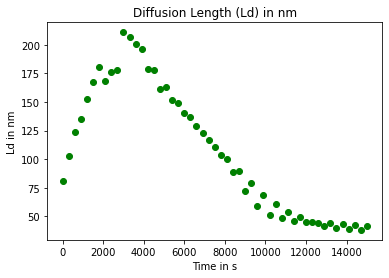

In [4]:
plt.scatter(df['t'], df['Low Freq LD [nm]'], c='green');
plt.xlabel('Time in s')
plt.ylabel('Ld in nm')
plt.title('Diffusion Length (Ld) in nm');

In [5]:
def get_PL_image(time):

    """
    Returns the image array when an integer time point is passed.
    
    Parameters
    -------------------
    time : int
        The time point of the PL image is to be loaded
        
    Returns
    -------------------
    numpy.ndarray
        The 2D array of the PL image
    
    """
    exp_name = exp_info['ExperimentID']
    image_path = '/'.join(['primary_vids', exp_name + '_grad0_loc0_time' + str(time), 'MMStack_Pos0.ome.tif'])
    
    # read the tiff image stack
    with zf.open(image_path) as file:
        img_stack = tf.imread(file)
     
    # Reorder axes to make it scikit-image compatible
    if len(img_stack.shape)>2:
        img_stack = np.swapaxes(img_stack,0,2)
        img_stack = np.swapaxes(img_stack,0,1)
    
    # If a regular 2D image, just return it
    if len(img_stack.shape)<3:
        return img_stack
    
    # Return the mean of pixels along the stacking axis
    return np.mean(img_stack, axis=2) 

In [6]:
image0 = get_PL_image(0)
channel_corners(image0, blur_kernel=1, threshold=10, get_square=True)

array([[  0,   0],
       [  0, 512],
       [512,   0],
       [512, 512]])

Text(0.5, 1.0, 'PL image at time point 50')

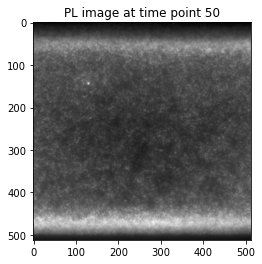

In [7]:
time = 50
img = get_PL_image(time)
plt.imshow(img, cmap='gray')
plt.title('PL image at time point ' + str(time))

In [8]:
train_data = []
viable_data = df[df['frame_corrupted'] == False].index.tolist() 
viable_data = [int(x) for x in viable_data] # get a list of viable photos (actual photos)
for time in viable_data:
    train_data.append(rescale(get_PL_image(time), 1/4, anti_aliasing=False)) # gets a training dataset rescaled

In [11]:
x_train = np.array(train_data) # Get into an np array
x_train = x_train / np.max(x_train) # normalize the data
x_train = x_train.astype('float32')

x_test = x_train[-10:] # Create test set

x_train = np.reshape(x_train, (len(x_train), 128, 128, 1))
x_test = np.reshape(x_test, (len(x_test), 128, 128, 1))


x_test.shape, x_train.shape

((10, 128, 128, 1), (50, 128, 128, 1))

# Autoencoder wrapper function

In [165]:
def auto_encoder(x_train, x_test, conv_layer):
    
    return_list = [conv_layer]
    
    input_img = keras.Input(shape=(128, 128, 1))
    
    #print(input_img.shape)
    x = layers.Conv2D(conv_layer[0], (3, 3), activation='relu', padding='same')(input_img)
    #print(x.shape)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    #print(x.shape)
    x = layers.Conv2D(conv_layer[1], (3, 3), activation='relu', padding='same')(x)
    #print(x.shape)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)
    #print(encoded.shape)


    #print('---------------')
    x = layers.Conv2D(conv_layer[1], (3, 3), activation='relu', padding='same')(encoded)
    #print(x.shape)
    x = layers.UpSampling2D((2, 2))(x)
    #print(x.shape)
    x = layers.Conv2D(conv_layer[0], (2, 2), activation='relu',padding='same')(x)
    #print(x.shape)
    x = layers.UpSampling2D((2, 2))(x)
    #print(x.shape)
    decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    #print(decoded.shape)

    autoencoder = keras.Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    
    history = History()
    history = autoencoder.fit(x_train, x_train,
                epochs=1,
                batch_size=50,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[history])
    
    return_list.append(history.history['val_loss'])
    return_list.append(history.history['loss'])
    
    return return_list, autoencoder
    

# Building Autoencoder

In [166]:
params, autoencoder = auto_encoder(x_train, x_test, [128,32])

Train on 50 samples, validate on 10 samples
Epoch 1/1
50/50 [==============================] - 9s 188ms/step - loss: 0.6931 - val_loss: 0.6921


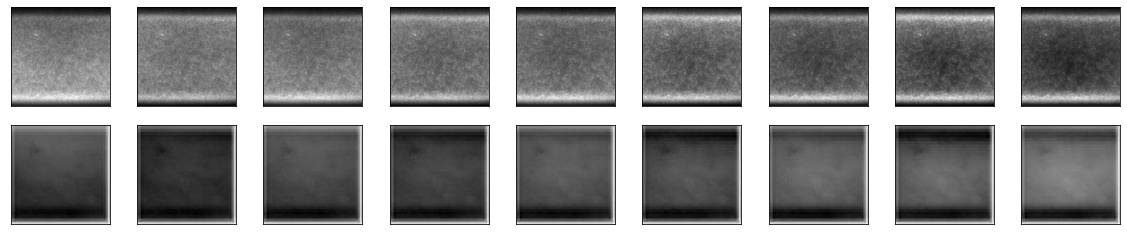

In [167]:
decoded_imgs = blah.predict(x_test)

n = 9
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(128, 128))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(128, 128))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

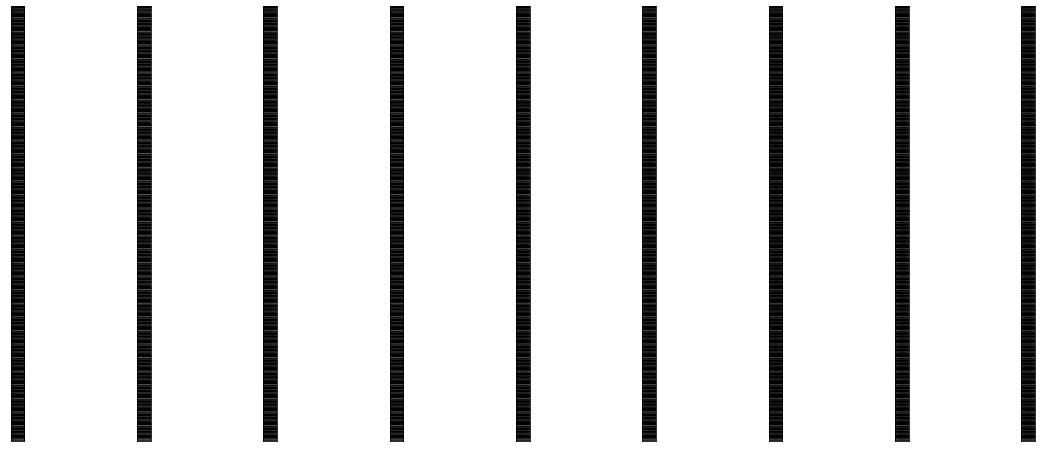

In [153]:
encoder = keras.Model(input_img, encoded)
encoded_imgs = encoder.predict(x_test)

n = 9
plt.figure(figsize=(20, 8))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(encoded_imgs[i].reshape((32, 32*32)).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()